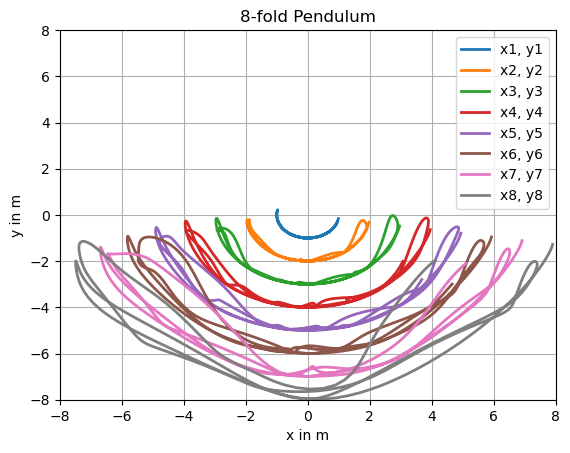


Time for initialization: 0.000507354736328125 seconds
Time for integration: 10.581954956054688 seconds
Time for x y conversion: 0.0 seconds
Time for plotting: 0.19218111038208008 seconds
Time for animation calculation: 0.06604218482971191 seconds

Time overall: 10.840685606002808

Angles used: [80.83582491889375, 80.83582491889375, 80.83582491889375, 80.83582491889375, 80.83582491889375, 80.83582491889375, 80.83582491889375, 80.83582491889375]
Velocities used: [0, 0, 0, 0, 0, 0, 0, 0]
Lengths used: [1, 1, 1, 1, 1, 1, 1, 1]
Masses used: [1, 1, 1, 1, 1, 1, 1, 1]



In [27]:

# Code for a single n-fold Pendulum; Kanes Method is used here

# ------------------------------------------------------------------------------------------------------------------------ #

# import all necessary packages
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time
import matplotlib
import random as rd

from sympy import symbols
from sympy.physics import mechanics

from sympy import Dummy, lambdify
from scipy.integrate import odeint

from matplotlib import animation

from IPython.display import HTML

# ------------------------------------------------------------------------------------------------------------------------ #

def integrate_pendulum(n, times, initial_positions, initial_velocities, lengths, masses):
    """
    Uses the Kane Methode to solve the equations of motion for a pendulum with n segments
    Define number of segments, simulation time, initial angles and angular velocities aswell as masses and lengths of each segment
    Specific steps are highlightes below with comments in code itself

    Args:
        n (int): number of segments of pendulum
        times (numpy array): numpy array of simulation time; defined over start and end time and number of steps
        initial_positions (list): list of initial angles of every pendulum segment
        initial_velocities (list): list of initial angular velocities of every pendulum segment
        lengths (list): list of lengths of every pendulum segment
        masses (list): list of masses of every pendulum segment

    Returns:
        p (): points p
    """

    #-------------------------------------------------
    # Step 1: construct the pendulum model
    
    # Generalized coordinates and velocities
    # (in this case, angular positions & velocities of each mass) 
    q = mechanics.dynamicsymbols('q:{0}'.format(n))
    u = mechanics.dynamicsymbols('u:{0}'.format(n))

    # mass and length
    m = symbols('m:{0}'.format(n))
    l = symbols('l:{0}'.format(n))

    # gravity and time symbols
    g, t = symbols('g,t')
    
    #--------------------------------------------------
    # Step 2: build the model using Kane's Method

    # Create pivot point reference frame
    A = mechanics.ReferenceFrame('A')
    P = mechanics.Point('P')
    P.set_vel(A, 0)

    # lists to hold particles, forces, and kinetic ODEs
    # for each pendulum in the chain
    particles = []
    forces = []
    kinetic_odes = []

    for i in range(n):
        # Create a reference frame following the i^th mass
        Ai = A.orientnew('A' + str(i), 'Axis', [q[i], A.z])
        Ai.set_ang_vel(A, u[i] * A.z)

        # Create a point in this reference frame
        Pi = P.locatenew('P' + str(i), l[i] * Ai.x)
        Pi.v2pt_theory(P, A, Ai)

        # Create a new particle of mass m[i] at this point
        Pai = mechanics.Particle('Pa' + str(i), Pi, m[i])
        particles.append(Pai)

        # Set forces & compute kinematic ODE
        forces.append((Pi, m[i] * g * A.x))
        kinetic_odes.append(q[i].diff(t) - u[i])

        P = Pi

    # Generate equations of motion
    KM = mechanics.KanesMethod(A, q_ind=q, u_ind=u, kd_eqs=kinetic_odes)
    fr, fr_star = KM.kanes_equations(particles, forces)
    
    #-----------------------------------------------------
    # Step 3: numerically evaluate equations and integrate

    # initial positions and velocities – assumed to be given in degrees
    y0 = np.deg2rad(np.concatenate([np.broadcast_to(initial_positions, n), np.broadcast_to(initial_velocities, n)]))
        
    # lengths and masses
    lengths = np.broadcast_to(lengths, n)
    masses = np.broadcast_to(masses, n)

    # Fixed parameters: gravitational constant, lengths, and masses
    parameters = [g] + list(l) + list(m)
    parameter_vals = [9.81] + list(lengths) + list(masses)

    # define symbols for unknown parameters
    unknowns = [Dummy() for i in q + u]
    unknown_dict = dict(zip(q + u, unknowns))
    kds = KM.kindiffdict()

    # substitute unknown symbols for qdot terms
    mm_sym = KM.mass_matrix_full.subs(kds).subs(unknown_dict)
    fo_sym = KM.forcing_full.subs(kds).subs(unknown_dict)

    # create functions for numerical calculation 
    mm_func = lambdify(unknowns + parameters, mm_sym)
    fo_func = lambdify(unknowns + parameters, fo_sym)

    # function which computes the derivatives of parameters
    def gradient(y, t, args):
        vals = np.concatenate((y, args))
        sol = np.linalg.solve(mm_func(*vals), fo_func(*vals))
        return np.array(sol).T[0]

    # ODE integration
    return odeint(gradient, y0, times, args=(parameter_vals,))

def get_xy_coords(p, lengths):
    """
    Get x and y coordinates from lengths of pendulums and p

    Args:
        p (): points p
        lengths (list): list of lengths of each pendulum

    Returns:
        x (): numpy cumsum with all x values
        y (): numpy cumsum with all y values
    """
    # calculate x and y coordinates from lengths and points; safe values in x and y array for animation
    p = np.atleast_2d(p)
    n = p.shape[1] // 2
    lengths_neg = [ -x for x in lengths]
    zeros = np.zeros(p.shape[0])[:, None]
    x = np.hstack([zeros, lengths * np.sin(p[:, :n])])
    y = np.hstack([zeros, lengths_neg * np.cos(p[:, :n])])
    return np.cumsum(x, 1), np.cumsum(y, 1)

def animate_pendulum(x, y):
    """
    Animates pendulum motion over x and y values; the figure and axes object are defined; creation of line object; definition of init and animate function
    Animate function: for each frame i every line is updated with values for this specific index i

    Args:
        x (List): list of all x values for every pendulum
        y (list): list of all y values for every pendulum

    Returns:
        anim (): animation object
    """
    # define plot and ax; set some parameters
    title = 'Pendel motion over time (Single Pendulum, ' + str(n) + "-fold)"
    fig = plt.figure()
    ax = fig.add_subplot(aspect='equal')
    ax.set_xlim(-1.05*sum_length, 1.05*sum_length)
    ax.set_ylim(-1.05*sum_length, 1.05*sum_length)
    ax.set_title(title)
    ax.set_xlabel('x in m')
    ax.set_ylabel('y in m')
    ax.grid(1)

    # initiate the line object here
    line, = ax.plot([], [], 'o-', lw=2)

    # initialize the line object
    def init():
        line.set_data([], [])
        return line,

    # animate the position of each line for every frame i
    def animate(i):
        line.set_data(x[i], y[i])
        return line,

    # create animation
    anim = animation.FuncAnimation(fig, animate, frames=len(times), interval=1000 * times.max() / len(times), blit=True, init_func=init)

    # closes the static plot which is not used here
    plt.close(fig)
    
    return anim

# ------------------------------------------------------------------------------------------------------------------------ #

# n is number of segments of the pendulum
n=3

# either random is 0 or 1
# random=1: choose a random start angle, mass and length for every pendulum; masses and length between 0 and 1; start angle between 0 and 360 degrees
# random=0: one random start angle is chosen that is applied to all pendulum segments; for this case every segment has length of 1m and mass of 1kg
random = 0

# time vector for simulation and animation; number of samples should not be changed to ensure real-time behaviour of animation and saved gif
# 50 fps chosen as gif could not be displayed with higher values and an increase would not be noticable for humans anyway
t_start = 0
t_end = 10
times = np.linspace(t_start, t_end, (t_end-t_start)*50)

# scaling factors for length and mass; change if necessary; if not used set to 1
# usefull because random function often produces values near to zero which is not good for nice simulation results
length_scaling = 2.5
mass_scaling = 5

# set data limit of animation; in MB; might need to be enlarged for other applications
matplotlib.rcParams['animation.embed_limit'] = 100.0

time_1 = time.time()

# ------------------------------------------------------------------------------------------------------------------------ #

# predefine empty lists and parameters
angles = []
velocities = []
lengths = []
masses = []
sum_length = 0

if random==1:
    # as decribed above: assign random angle, mass and length for every pendulum segment; if necessary use scaling factors
    # append values to lists; add sum_length in each cycle up; used for scaling of plot and animation
    for i in range(n):
        rand_angles = rd.random()
        rand_lengths = rd.random() * length_scaling
        rand_masses = rd.random() * mass_scaling
        angles.append(rand_angles*360)
        velocities.append(0)
        lengths.append(rand_lengths)
        masses.append(rand_masses)
        sum_length = sum_length + rand_lengths
else:
    # one random angle for all pendulums
    rand_angles = rd.random()

    #create lists and sum_length as mentioned above
    for i in range(n):
        angles.append(rand_angles*360)
        velocities.append(0)
        lengths.append(1)
        masses.append(1)
        sum_length = sum_length + 1

time_2 = time.time()

# ------------------------------------------------------------------------------------------------------------------------ #

# integrate pendulum and create p
p = integrate_pendulum(n, times, angles, velocities, lengths, masses)

time_3 = time.time()

# ------------------------------------------------------------------------------------------------------------------------ #

# get x and y coordinates from p and lengths
x, y = get_xy_coords(p, lengths)

time_4 = time.time()

# ------------------------------------------------------------------------------------------------------------------------ #

# reform x and y values so that e.g. all x values for one pendulum segment are in one list, which gots appended to x_list; same for y
x_list = []
y_list = []
for o in range(1,n+1):
    x_temp = []
    y_temp = []
    for i in range(len(times)):
        x_temp.append(x[i][o])
        y_temp.append(y[i][o])
    x_list.append(x_temp)
    y_list.append(y_temp)

# plot y over x values; plot each x and y entry seperatly for adding of label
for i in range(n):
    label_loop = "x" + str(i+1) + ", y" + str(i+1)
    plt.plot(x_list[i], y_list[i], lw=2, label=label_loop)

title = str(n) + '-fold Pendulum'
plt.title(title)
plt.xlabel('x in m')
plt.ylabel('y in m')
plt.ylim(-sum_length, sum_length)
plt.xlim(-sum_length, sum_length)
plt.grid()
plt.legend()
plt.show()

time_5 = time.time()

# ------------------------------------------------------------------------------------------------------------------------ #

# create animation
anim = animate_pendulum(x, y)

time_6 = time.time()

# ------------------------------------------------------------------------------------------------------------------------ #

# evaluation of times; not necessary for function
times_initialization = time_2 - time_1
times_integration = time_3 - time_2
times_x_y_conversion = time_4 - time_3
times_plotting = time_5 - time_4
times_animation = time_6 - time_5

print("")
print("Time for initialization:", times_initialization, "seconds")
print("Time for integration:", times_integration, "seconds")
print("Time for x y conversion:", times_x_y_conversion, "seconds")
print("Time for plotting:", times_plotting, "seconds")
print("Time for animation calculation:", times_animation, "seconds")
print("")
print("Time overall:", time_6 - time_1)
print("")

print("Angles used:", angles)
print("Velocities used:", velocities)
print("Lengths used:", lengths)
print("Masses used:", masses)
print("")


In [28]:

# execute/open animation with this line
#HTML(anim.to_jshtml())

# create name for give in dependence of n
name_gif = "Single_" + str(n) + "-fold_Pendulum.gif"

# save animation as gif to document results; dpi could be varied; do not change fps value: otherwise no real time behaviour!
from matplotlib.animation import FuncAnimation, PillowWriter
anim.save(name_gif, dpi=300, writer=PillowWriter(fps=50))
